In [ ]:
#for < 5cm cover, ablation rate = 6 cm/day
#below that goes from 4 cm/day at 5 to 1 at 40cm 3m/year/35cm cover

In [60]:
#Import numpy for arrays
import numpy as np
#Import matplotlib.pyplot for plotting
import matplotlib.pyplot as plt
#Import Landlab raster arrays
from landlab import RasterModelGrid 
#Import landlab graph plotting
from landlab.plot.graph import plot_graph
from landlab import imshowhs_grid, imshow_grid
from landlab.io.netcdf import write_netcdf, read_netcdf
from IPython.display import clear_output
# Standard library imports
import os
import time
import warnings
import copy
import pickle
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, SymLogNorm

In [187]:
thaw_days = 100
dt = 1

#create ThawIce class
class ThawIce:
    #define function and input
    def __init__ (self, ice_thickness = 'z_ice', soil_thickness = 'z_soil', thaw_rate = thaw_rate, thaw_days_per_year = thaw_days, timestep_years = dt):
        self.ice_thickness = ice_thickness 
        self.soil_thickness = soil_thickness
        self.thaw_days = thaw_days_per_year
        self.dt = timestep_years
    #define thaw function and inputs (dt is number of days
    
    def thaw(self):
            thaw_rate = []
            for i in range(len(self.soil_thickness)):
                if self.soil_thickness[i] <= 0.05: #m
                    thaw_rate.append(self.thaw_days * 0.06) #m/yr
                elif  0.05 < self.soil_thickness[i] < 51.7:
                    thaw_rate.append(0.0857*self.soil_thickness[i]*self.thaw_days)
                elif self.soil_thickness[i] >= 51.7:
                    thaw_rate.append(0)
            self.thaw_rate = thaw_rate
            for i in range(len(self.ice_thickness)):
                if self.ice_thickness[i] >= self.thaw_rate[i]*self.dt:
                    self.ice_thickness[i] = self.ice_thickness[i] - self.dt*self.thaw_rate[i]
                else:
                    self.ice_thickness[i] = 0


In [189]:
#define the grid
size_x = 100
size_y = 200
spacing = 1.0
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)

# morph the grid with a sine function
ice_height = 10
bedrock_slope = 0.22
soil_thickness = 100
moraine_disappears_at_y = 100

# add the topography    
z_ice = grid.add_zeros('ice_thickness', at='node')
z_soil = grid.add_zeros('soil_thickness', at='node')
z_bed = grid.add_zeros('bedrock_thickness', at='node')
elev = grid.add_zeros('topographic__elevation', at='node')

x = grid.x_of_node
y = grid.y_of_node

# setting ice elevation respected to the base elevation
z = ice_height * np.sin(np.pi*x / (size_x/3)) 
# get z where y is less than moraine_disappears_at_y
z[y<moraine_disappears_at_y] += (y[y<moraine_disappears_at_y] - moraine_disappears_at_y) * ice_height/moraine_disappears_at_y
z[z<0] = 0 # cut the sine function at 0

z_ice += z
z_soil += soil_thickness
z_bed += bedrock_slope * y
def calc_elev(z_ice, z_soil, z_bed):
    elev = z_ice + z_soil + z_bed
    return elev

elev = calc_elev(z_ice,z_soil,z_bed)    

# add boundaries
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_CLOSED
# grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED

#grid.imshow(elev)

In [89]:
def run_model_with_output(scen_num,
              mg_name,
              total_time,
              time_step,
              rows,
              columns,
              node_spacing,
              thaw_rate,
              plotting="true",
              plotting_interval=1,
              is_new_run="True",
              save_plots="False",
              output_format='netcdf',
              output_interval=1):
    """
    Run model and save grid states at specified intervals.
Parameters:
    -----------
    scen_num : int
    mg_name : RasterModelGrid
        The model grid to run the model on.
    total_time : float
        Total time to run the model for.
    time_step : float
        Timestep for the model.
    rows : int
        Number of rows in the model grid.
    columns : int
        Number of columns in the model grid.
    node_spacing : float
        Spacing between nodes in the model grid.
    plotting : str
        Whether to plot the model output.
    plotting_interval : int
        Number of timesteps between each plot.
    new_grid : str
        Whether to create a new grid for the model.
    is_new_run : str
        Whether this is a new run of the model.
    save_plots : str
        Whether to save the plots.
    output_format : str
        Format to save the output. Either 'netcdf' or 'pickle'.
    output_interval : int
        Number of timesteps between each save of the grid state.
    Returns:
    mg_name : RasterModelGrid
        The final state of the model grid.
    """
    # Initialize bookkeeping variables
    scenario_num = scen_num
    num_rows = rows
    num_columns = columns
    ndt = int(total_time // time_step)
    # Initialize output storage
    grid_states = []
    start_time = time.time()
    # Time loop
    for i in range(ndt + 1):
        # Thaw and update elevation
        for i in range(len(z_ice)):
            if z_ice[i] >= thaw_rate*time_step:
                z_ice[i] = z_ice[i] - thaw_rate*time_step
            else:
                z_ice[i] = 0
        mg_name.at_node['topographic__elevation'][:] = calc_elev(z_ice, z_soil, z_bed)
        clear_output(wait = True)
        mg_name.imshow('ice_thickness', at = 'node')
        # Update progress bar
        #elapsed_time = time.time() - start_time
        #estimated_total_time = elapsed_time * (ndt + 1) / (i + 1)
        #time_remaining = estimated_total_time - elapsed_time
    # Save the final output file
    output_dir = f'scenario_{scen_num}_output'
    os.makedirs(output_dir, exist_ok=True)
    output_filename = f'{output_dir}/grid_states.pkl'
    with open(output_filename, 'wb') as f:
        pickle.dump(grid_states, f)
    print(f"\nSaved grid states to {output_filename}")
    print(f"Total runtime: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")
    return mg_name

RasterModelGrid((200, 100), xy_spacing=(np.float64(1.0), np.float64(1.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0)))

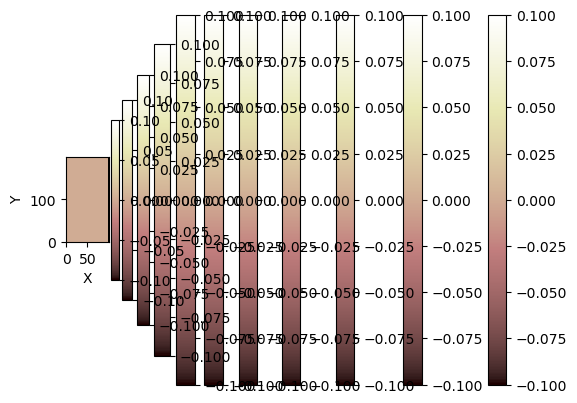

In [90]:
total_time = 10
dt = 1
thaw_rate = 1

run_model_with_output(scen_num = 1,
              mg_name = grid,
              total_time = total_time,
              time_step = dt,
              rows = grid.y_of_node,
              columns = grid.x_of_node,
              node_spacing = 1,
              thaw_rate = thaw_rate,
              plotting="true",
              plotting_interval=1,
              is_new_run="True",
              save_plots="False",
              output_format='netcdf',
              output_interval=1)

NameError: name 'Unpickler' is not defined

In [52]:
pickle.load('repositories/2025-glacier-outbursts/scenario_1_output/grid_states.pkl', fix_imports=True, encoding='netcdf', errors='strict', buffers=None)

TypeError: file must have 'read' and 'readline' attributes

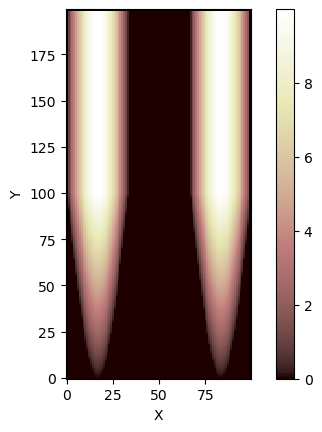

In [190]:
#thaw_rate = calc_thaw()
oop = ThawIce(ice_thickness = z_ice, soil_thickness = z_soil)
oop.thaw ()
grid.imshow(oop.ice_thickness)